In [1]:
#importing modules
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from keras.layers import BatchNormalization,Dropout
import numpy as np
from tensorflow.keras.regularizers import L2
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import EfficientNetB0

In [2]:
#loading dataset 
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "Dataset",
    image_size=(256,256),
    batch_size=32
)

Found 2702 files belonging to 2 classes.


In [3]:
class_names=dataset.class_names
class_names

['Negative', 'Positive']

In [4]:
#A function to split the dataset into training,validation and testing
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    
    ds_size = len(ds)
    
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [5]:
#Splitting the dataset into training, validation and testing
train_ds, val_ds, test_ds=get_dataset_partitions_tf(dataset)

In [6]:
#Shuffling and PreFetching the dataset
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [7]:
EfficientNet_BO = EfficientNetB0(
    weights="imagenet",
    include_top=False,
    input_shape=(256, 256, 3)
)

# Freeze pretrained layers
for layer in EfficientNet_BO.layers:
    layer.trainable = False

model = Sequential()
model.add(EfficientNet_BO)
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(2, activation='softmax'))


In [8]:
#Compiling the model
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [9]:
#Training the model
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
history = model.fit(
    train_ds,
    batch_size=32,
    validation_data=val_ds,
    verbose=1,
    epochs=40,
    callbacks=[early_stopping])

Epoch 1/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 29s 372ms/step - accuracy: 0.7574 - loss: 4.4248 - val_accuracy: 0.8789 - val_loss: 0.2860
Epoch 2/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 23s 341ms/step - accuracy: 0.9321 - loss: 0.2062 - val_accuracy: 0.9531 - val_loss: 0.1145
Epoch 3/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 24s 347ms/step - accuracy: 0.9232 - loss: 0.1878 - val_accuracy: 0.9688 - val_loss: 0.1029
Epoch 4/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 24s 350ms/step - accuracy: 0.9607 - loss: 0.1017 - val_accuracy: 0.9648 - val_loss: 0.0813
Epoch 5/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 24s 356ms/step - accuracy: 0.9717 - loss: 0.0678 - val_accuracy: 0.9531 - val_loss: 0.0811
Epoch 6/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 24s 357ms/step - accuracy: 0.9643 - loss: 0.0831 - val_accuracy: 0.9766 - val_loss: 0.0656
Epoch 7/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 24s 359ms/step - accuracy: 0.9797 - loss: 0.0567 - val_accuracy: 0.9805 - val_loss: 0.0525
Epoch 8/40
68/68 ━━━━━━━━━━━━━━━━━━━━ 25s 367ms/step - accuracy: 0.9806 - loss: 0.0505 - val_accu

In [10]:
model.evaluate(test_ds)

9/9 ━━━━━━━━━━━━━━━━━━━━ 4s 297ms/step - accuracy: 0.9613 - loss: 0.1873


[0.14735732972621918, 0.96875]

In [11]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

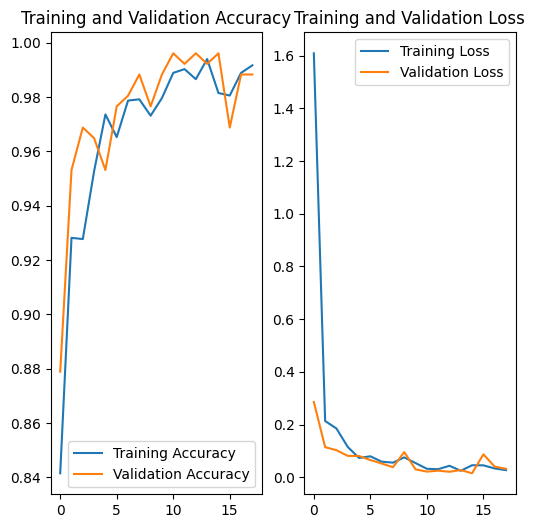

In [12]:
plt.figure(figsize=(6, 6))
plt.subplot(1, 2, 1)
plt.plot(range(18), acc, label='Training Accuracy')
plt.plot(range(18), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(18), loss, label='Training Loss')
plt.plot(range(18), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [13]:
import numpy as np
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 585ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


2026-02-25 17:23:47.153039: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


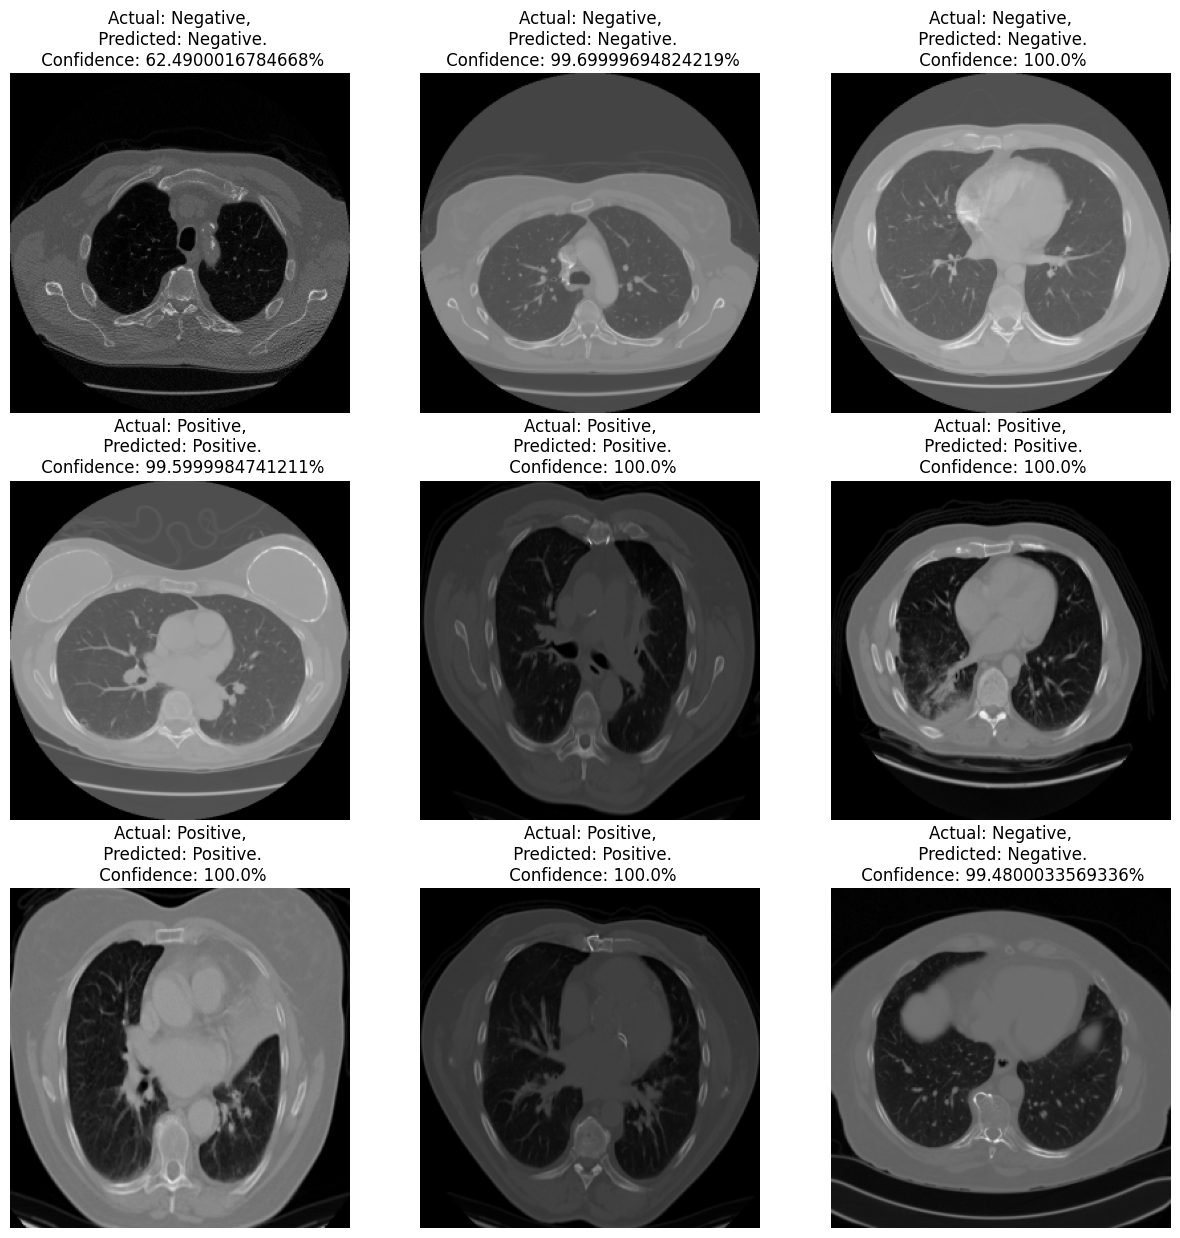

In [14]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]] 
        
        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        
        plt.axis("off")

2026-02-25 17:24:05.070118: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


X_test shape: (288, 256, 256, 3)
y_true shape: (288,)
9/9 ━━━━━━━━━━━━━━━━━━━━ 3s 300ms/step


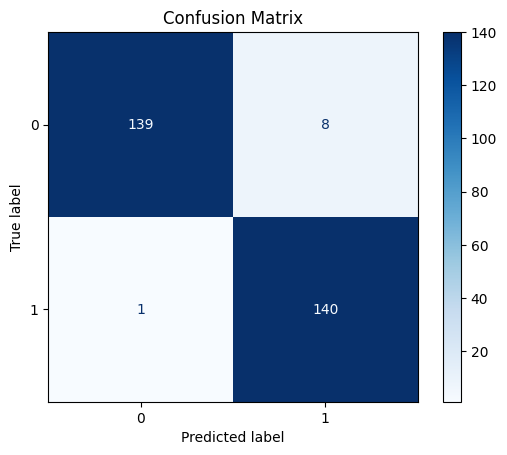


Classification Report:
              precision    recall  f1-score   support

           0       0.99      0.95      0.97       147
           1       0.95      0.99      0.97       141

    accuracy                           0.97       288
   macro avg       0.97      0.97      0.97       288
weighted avg       0.97      0.97      0.97       288



In [15]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report


#Convert test_ds → NumPy arrays

X_test = []
y_true = []

for images, labels in test_ds:
    X_test.append(images)
    y_true.append(labels)

X_test = np.concatenate(X_test)
y_true = np.concatenate(y_true)

print("X_test shape:", X_test.shape)
print("y_true shape:", y_true.shape)


# Predict using your trained model

y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)


# Confusion Matrix

cm = confusion_matrix(y_true, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()


#Classification Report

print("\nClassification Report:")
print(classification_report(y_true, y_pred_classes))

In [16]:
model.save("saved_models/efficientnet_bo.h5")